## **Description**

The goal of this project is to predict if a person has any of three medical conditions. If the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0).
>
To determine if someone has these medical conditions requires a long and intrusive process to collect information from patients. With predictive models, we can shorten this process and keep patient details private by collecting key characteristics relative to the conditions, then encoding these characteristics.

The project will help researchers discover the relationship between measurements of certain characteristics and potential patient conditions.

## **Context**
They say age is just a number but a whole host of health issues come with aging. From heart disease and dementia to hearing loss and arthritis, aging is a risk factor for numerous diseases and complications. The growing field of bioinformatics includes research into interventions that can help slow and reverse biological aging and prevent major age-related ailments. Data science could have a role to play in developing new methods to solve problems with diverse data, even if the number of samples is small.
>
Currently, models like XGBoost and random forest are used to predict medical conditions yet the models' performance is not good enough. Dealing with critical problems where lives are on the line, models need to make correct predictions reliably and consistently between different cases.
>
Founded in 2015, ***InVitro Cell Research***, LLC (ICR) is a privately funded company focused on regenerative and preventive personalized medicine. Their offices and labs in the greater New York City area offer state-of-the-art research space. InVitro Cell Research's Scientists are what set them apart, helping guide and defining their mission of researching how to repair aging people fast.
>
In this project, I'll be working with measurements of health characteristic data to solve critical problems in bioinformatics. Based on minimal training, I'll create a model to predict if a person has any of three medical conditions, with an aim to improve on existing methods.
>
This could help advance the growing field of bioinformatics and explore new methods to solve complex problems with diverse data.

In [1]:
!pip install --quiet optuna
!pip install --quiet catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 5.8 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import optuna
from catboost import CatBoostClassifier
import warnings

warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

In [3]:
train_df = pd.read_csv ('https://raw.githubusercontent.com/DigitDynamo/Identifying_Age_Related_Conditions/main/train.csv')
test_df = pd.read_csv ('https://raw.githubusercontent.com/DigitDynamo/Identifying_Age_Related_Conditions/main/test.csv')
greeks_df = pd.read_csv ('https://raw.githubusercontent.com/DigitDynamo/Identifying_Age_Related_Conditions/main/greeks.csv')
sample_submission = pd.read_csv ('https://raw.githubusercontent.com/DigitDynamo/Identifying_Age_Related_Conditions/main/sample_submission.csv')

In [4]:
# Data overview
print(train_df.shape)
print(train_df.describe())
print(train_df.info())

(617, 58)
               AB            AF           AH          AM          AR  \
count  617.000000    617.000000   617.000000  617.000000  617.000000   
mean     0.477149   3502.013221   118.624513   38.968552   10.128242   
std      0.468388   2300.322717   127.838950   69.728226   10.518877   
min      0.081187    192.593280    85.200147    3.177522    8.138688   
25%      0.252107   2197.345480    85.200147   12.270314    8.138688   
50%      0.354659   3120.318960    85.200147   20.533110    8.138688   
75%      0.559763   4361.637390   113.739540   39.139886    8.138688   
max      6.161666  28688.187660  1910.123198  630.518230  178.943634   

               AX          AY          AZ           BC           BD   \
count  617.000000  617.000000  617.000000   617.000000    617.000000   
mean     5.545576    0.060320   10.566447     8.053012   5350.388655   
std      2.551696    0.416817    4.350645    65.166943   3021.326641   
min      0.699861    0.025578    3.396778     1.22990

In [5]:
# Preprocessing data
all_cols = train_df.columns
non_use_cols = ['Id', 'Class']
feature_cols = [col for col in all_cols if col not in non_use_cols]
print(feature_cols)

['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']


In [6]:
print(train_df["EJ"].unique())
print(train_df["EJ"].value_counts())
train_df["EJ"] = train_df["EJ"].apply(lambda x: 0 if x == 'A' else 1)

['B' 'A']
EJ
B    395
A    222
Name: count, dtype: int64


In [7]:
# Split data into training and testing sets
y = train_df['Class'].copy()
x = train_df[feature_cols].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [8]:
# Train CatBoost model
model = CatBoostClassifier(iterations=300, learning_rate=0.1, depth=6, verbose=0)
model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=50)


In [9]:
# Prepare test data
test_df["EJ"] = test_df["EJ"].apply(lambda x: 0 if x == "A" else 1)
test = test_df[feature_cols].copy()
pred = pd.DataFrame(model.predict_proba(test))

In [10]:
# Create submission file
sample_submission['Id'] = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('submission.csv')
print(sample_submission)

             Id   class_0   class_1
0  00eed32682bb  0.873431  0.126569
1  010ebe33f668  0.873431  0.126569
2  02fa521e1838  0.873431  0.126569
3  040e15f562a2  0.873431  0.126569
4  046e85c7cc7f  0.873431  0.126569


In [16]:
# Hyperparameter tuning with Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'verbose': 0
    }

    model = CatBoostClassifier(**params)
    model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=50, verbose=False)
    y_pred = model.predict_proba(x_test)[:, 1]
    score = log_loss(y_test, y_pred)

    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best parameters: ", best_params)

[I 2024-05-15 19:33:08,413] A new study created in memory with name: no-name-5f513035-bdbd-41eb-a193-1c41e16458d9
[I 2024-05-15 19:33:11,048] Trial 0 finished with value: 0.1436095718895657 and parameters: {'iterations': 583, 'learning_rate': 0.09434528451091267, 'depth': 5}. Best is trial 0 with value: 0.1436095718895657.
[I 2024-05-15 19:33:30,906] Trial 1 finished with value: 0.26965073275548757 and parameters: {'iterations': 436, 'learning_rate': 0.0032437972653099104, 'depth': 8}. Best is trial 0 with value: 0.1436095718895657.
[I 2024-05-15 19:33:34,473] Trial 2 finished with value: 0.17773845193758936 and parameters: {'iterations': 158, 'learning_rate': 0.02736878798941332, 'depth': 6}. Best is trial 0 with value: 0.1436095718895657.
[I 2024-05-15 19:33:51,455] Trial 3 finished with value: 0.15267318391697238 and parameters: {'iterations': 872, 'learning_rate': 0.016696504567939384, 'depth': 7}. Best is trial 0 with value: 0.1436095718895657.
[I 2024-05-15 19:33:53,251] Trial 4 

Best parameters:  {'iterations': 846, 'learning_rate': 0.060388944704836904, 'depth': 5}


In [17]:
# Train final model with best parameters
model = CatBoostClassifier(**best_params)
model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=50, verbose=0)

In [18]:
# Predictions with the final model
pred = pd.DataFrame(model.predict_proba(test))

In [19]:
# Create submission file with the final model
sample_submission['Id'] = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('final_submission.csv')
print(sample_submission)

             Id   class_0   class_1
0  00eed32682bb  0.894671  0.105329
1  010ebe33f668  0.894671  0.105329
2  02fa521e1838  0.894671  0.105329
3  040e15f562a2  0.894671  0.105329
4  046e85c7cc7f  0.894671  0.105329


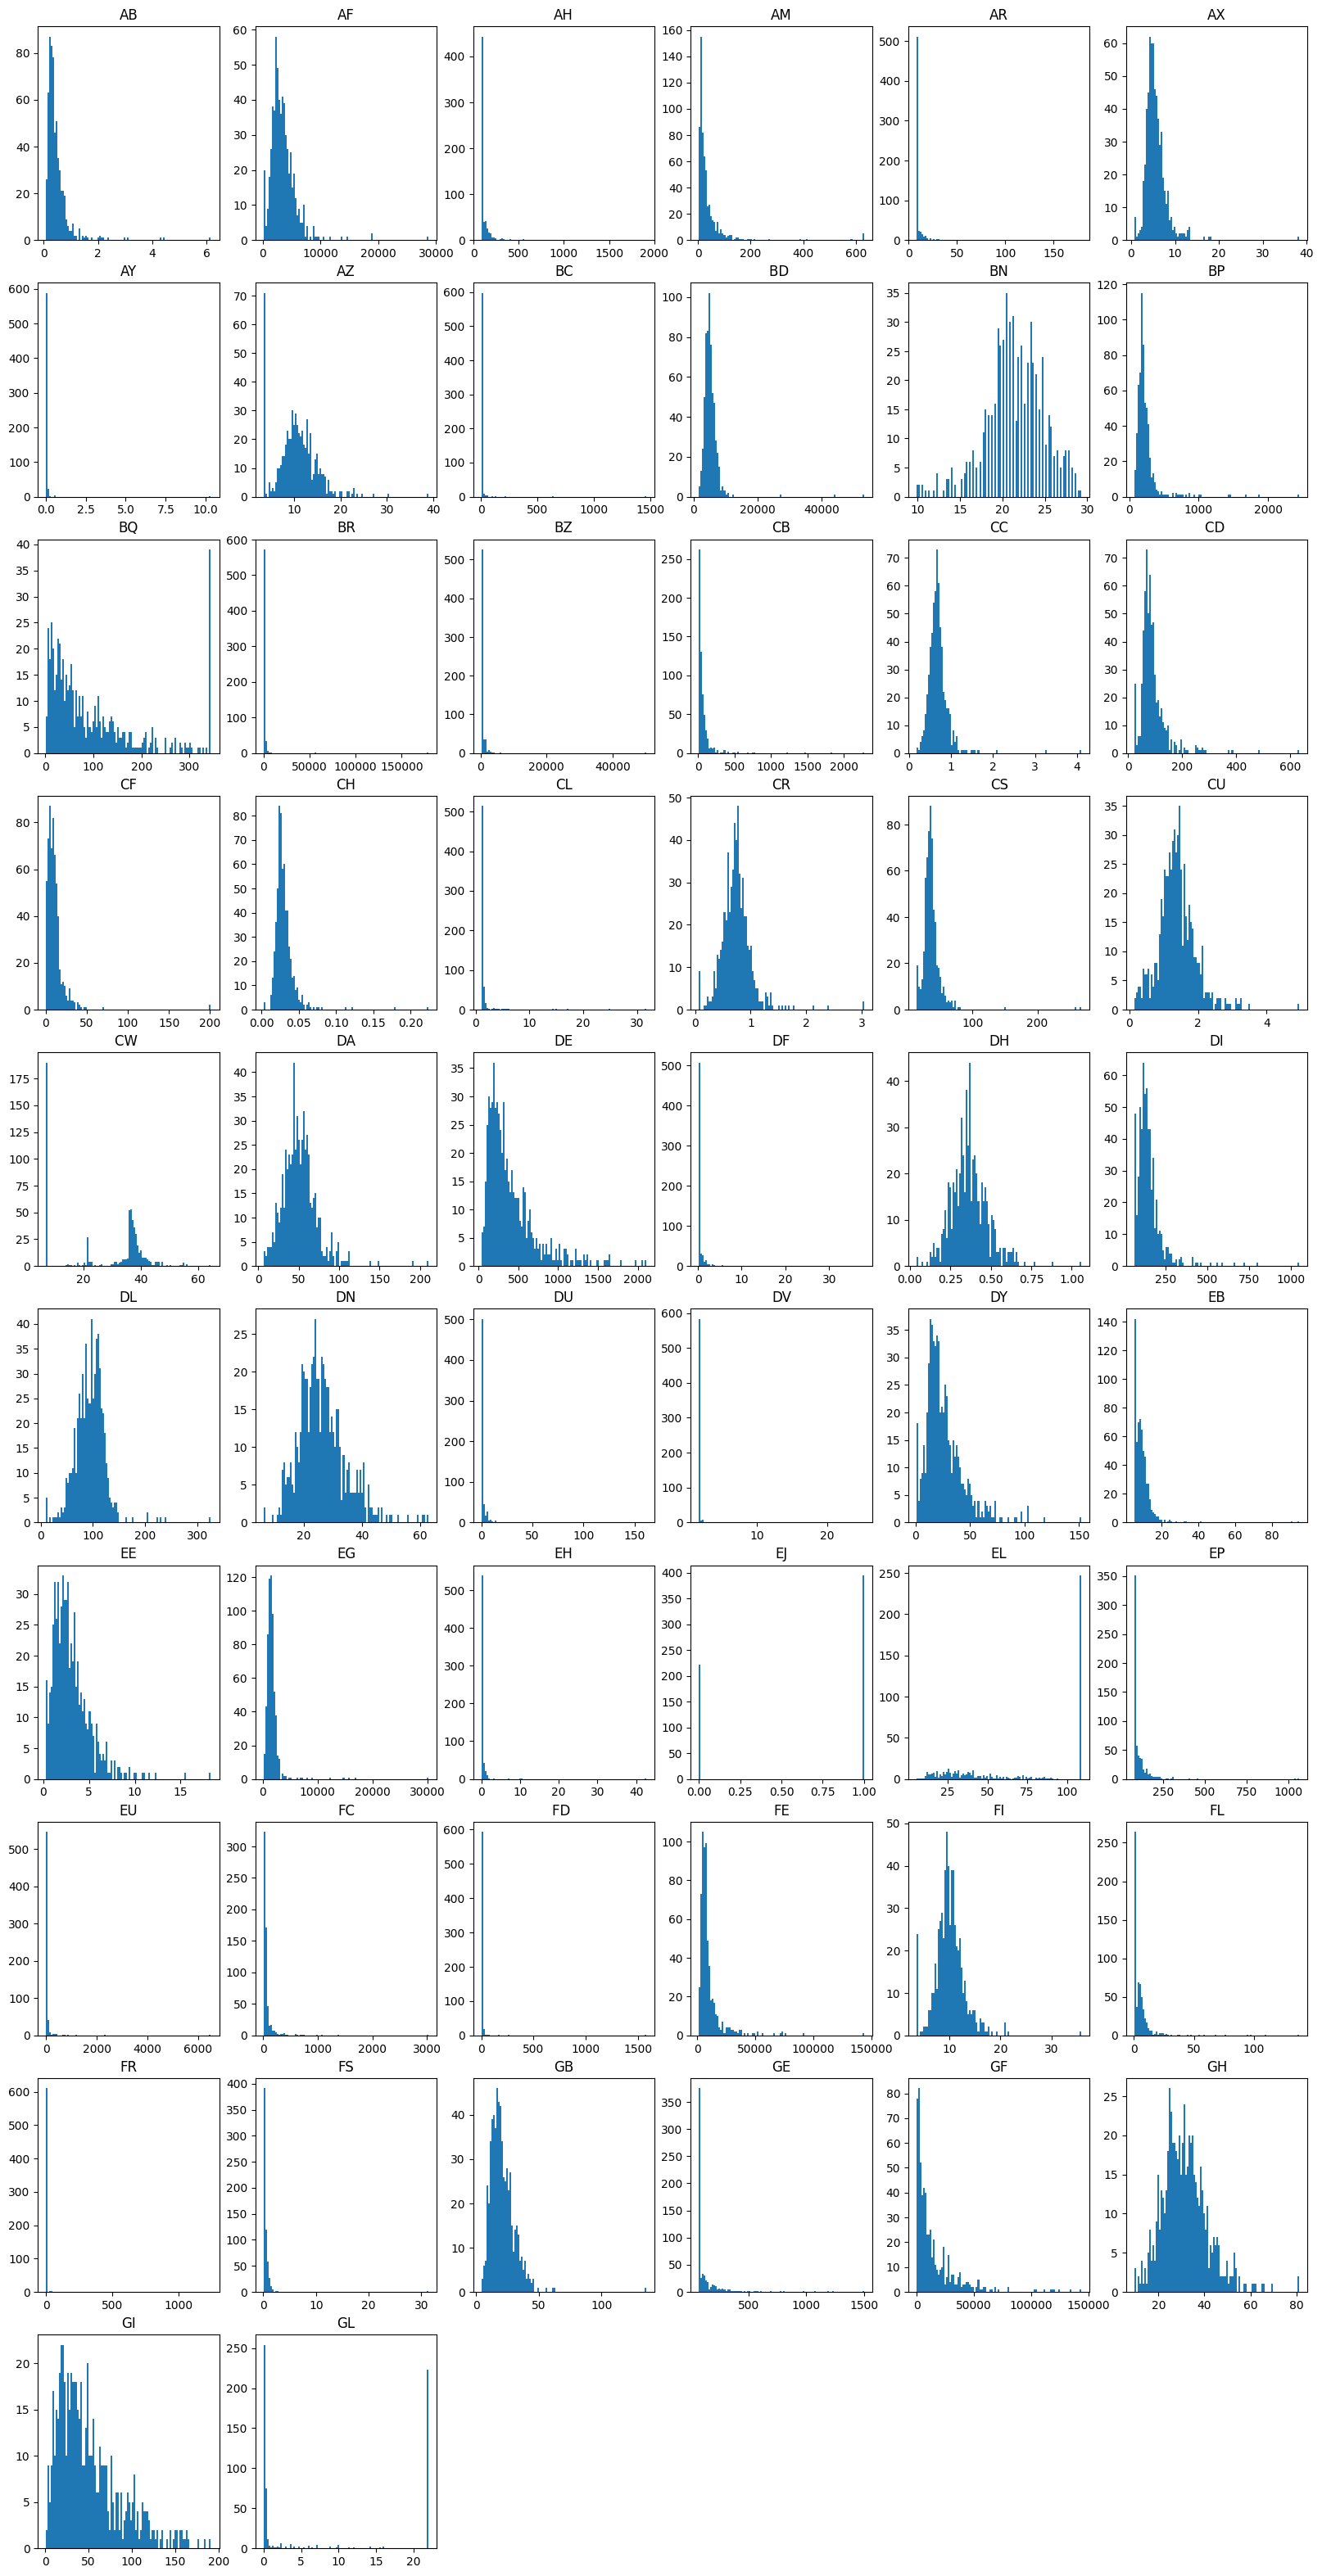

In [20]:
# Plotting feature importance
plt.figure(figsize=(20, 40))
for i, col in enumerate(feature_cols):
    plt.subplot(10, 6, i+1)
    plt.hist(train_df[col], bins=100)
    plt.title(col)
plt.show()

In [21]:
# Outlier detection
outlier_list = []
for col in feature_cols:
    temp_df = train_df[train_df[col] > train_df[col].mean() + train_df[col].std() * 20]
    if len(temp_df) > 0:
        outliers = temp_df.index.to_list()
        outlier_list.extend(outliers)
        print(col, len(temp_df), temp_df.index)

outlier_list = list(set(outlier_list))
print(len(outlier_list))

AY 1 Index([10], dtype='int64')
BC 1 Index([378], dtype='int64')
BR 1 Index([155], dtype='int64')
BZ 1 Index([378], dtype='int64')
EH 1 Index([511], dtype='int64')
FD  1 Index([511], dtype='int64')
FR 1 Index([160], dtype='int64')
FS 1 Index([349], dtype='int64')
6


In [22]:
# Remove outliers and retrain
train_df = train_df.drop(index=outlier_list)


In [23]:
y = train_df['Class'].copy()
x = train_df[feature_cols].copy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [24]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
best_params = study.best_params
print("Best parameters after outlier removal: ", best_params)

[I 2024-05-15 19:50:13,550] A new study created in memory with name: no-name-4f347e86-654e-4001-b842-ac712c1ec945
[I 2024-05-15 19:50:44,109] Trial 0 finished with value: 0.21343536999003254 and parameters: {'iterations': 378, 'learning_rate': 0.012708786915139129, 'depth': 9}. Best is trial 0 with value: 0.21343536999003254.
[I 2024-05-15 19:51:04,148] Trial 1 finished with value: 0.33473837084832087 and parameters: {'iterations': 441, 'learning_rate': 0.0017495144638704785, 'depth': 8}. Best is trial 0 with value: 0.21343536999003254.
[I 2024-05-15 19:51:23,280] Trial 2 finished with value: 0.23027935087728302 and parameters: {'iterations': 143, 'learning_rate': 0.043449969595028004, 'depth': 10}. Best is trial 0 with value: 0.21343536999003254.
[I 2024-05-15 19:51:25,995] Trial 3 finished with value: 0.20243862126209747 and parameters: {'iterations': 699, 'learning_rate': 0.044336723962667766, 'depth': 6}. Best is trial 3 with value: 0.20243862126209747.
[I 2024-05-15 19:51:35,848] 

Best parameters after outlier removal:  {'iterations': 446, 'learning_rate': 0.024066108514725956, 'depth': 4}


In [25]:
model = CatBoostClassifier(**best_params)
model.fit(x_train, y_train, eval_set=(x_test, y_test), early_stopping_rounds=50, verbose=0)

pred = pd.DataFrame(model.predict_proba(test))

In [26]:
sample_submission['Id'] = test_df.reset_index()['Id']
sample_submission["class_0"] = pred[0]
sample_submission["class_1"] = pred[1]
sample_submission.set_index('Id').to_csv('final_submission_after_outlier_removal.csv')
print(sample_submission)

             Id   class_0   class_1
0  00eed32682bb  0.864061  0.135939
1  010ebe33f668  0.864061  0.135939
2  02fa521e1838  0.864061  0.135939
3  040e15f562a2  0.864061  0.135939
4  046e85c7cc7f  0.864061  0.135939
